# Import Dependencies

In [1]:
# audio libraries
import librosa
import librosa.display as lplt
import IPython

# import matplotlib to be able to display graphs
import matplotlib.pyplot as plt

# transform .wav into .csv
import csv
import os
import numpy as np
import pandas as pd

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# model
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential

/home/camilla/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-12-16 13:51:22.176569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734353482.271289    7455 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734353482.299311    7455 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 13:51:22.526794: I tensorflow/core/platform/cpu_fe

# Apply augmentations and extend the dataset

almost done, run again from northern right or check manually 

In [ ]:
import os
import numpy as np
import librosa
from scipy.io.wavfile import write

# Function to save augmented audio in the same folder
def save_audio(audio, sample_rate, folder, original_filename, augmentation_name):
    augmented_filename = f"{os.path.splitext(original_filename)[0]}_{augmentation_name}.wav"
    augmented_path = os.path.join(folder, augmented_filename)
    write(augmented_path, sample_rate, (audio * 32767).astype(np.int16))  # Convert to int16
    return augmented_path

# Function to apply augmentations
def apply_augmentations(audio, sample_rate):
    augmentations = {
        'pitch_shift': lambda x: librosa.effects.pitch_shift(y=x, sr=sample_rate, n_steps=2),
        'time_stretch': lambda x: librosa.effects.time_stretch(x, rate=1.1),
        'add_noise': lambda x: x + 0.005 * np.random.normal(size=x.shape),
        'time_shift': lambda x: np.roll(x, int(0.1 * sample_rate)),  # Shift by 10% of sample rate
    }
    augmented_audios = {}
    for aug_name, aug_func in augmentations.items():
        try:
            augmented_audios[aug_name] = aug_func(audio)
        except Exception as e:
            print(f"Error applying {aug_name}: {e}")
    return augmented_audios

# Function to handle the resampling issue and adjust n_fft dynamically for shorter signals
def process_audio(file_path):
    try:
        # Load audio and resample to 10 kHz
        audio, _ = librosa.load(file_path, sr=10000)
        
        # Adjust n_fft if necessary for shorter audio signals
        if len(audio) < 2048:
            n_fft = len(audio)  # Use the length of the signal as the n_fft size if smaller than 2048
        else:
            n_fft = 2048
        
        # Apply augmentations
        augmented_audios = apply_augmentations(audio, 10000)
        
        return augmented_audios, audio  # Return the augmented audios along with the original audio
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None

# Iterate through the selected folders and process audio files
main_dir = "data/"  # Replace with your directory path

# List of selected folders (species)
selected_folders = [
    "BowheadWhale",
    "Beluga_WhiteWhale",
    # "SouthernRightWhale",
    # "NorthernRightWhale",
    "Short_Finned(Pacific)PilotWhale",
    "Long_FinnedPilotWhale",
    "HumpbackWhale",
    "KillerWhale",
    # "SpermWhale",
    # "Rough_ToothedDolphin",
    "ClymeneDolphin",
    "BottlenoseDolphin"
]


if os.path.exists(main_dir):
    all_folders = os.listdir(main_dir)
    
    for folder in all_folders:
        # Skip non-selected folders
        if folder not in selected_folders:
            print(f"Skipping '{folder}' as it's not in the selected folders.")
            continue
        
        folder_path = os.path.join(main_dir, folder)
        
        # Skip non-directories
        if not os.path.isdir(folder_path):
            print(f"Skipping '{folder}' as it is not a directory.")
            continue
        
        # List all audio files in the folder
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.wav', '.mp3'))]
        
        for file in files:
            file_path = os.path.join(folder_path, file)
            
            # Process each audio file
            augmented_audios, _ = process_audio(file_path)
            
            if augmented_audios:
                # Save each augmented audio file in the same folder
                for aug_name, aug_audio in augmented_audios.items():
                    save_audio(aug_audio, 10000, folder_path, file, aug_name)

else:
    print("Directory does not exist.")


# Feature Extraction

In [2]:
header = "filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean \
        spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var harmony_mean harmony_var perceptr_mean \
        perceptr_var tempo mfcc1_mean mfcc1_var mfcc2_mean mfcc2_var mfcc3_mean mfcc3_var mfcc4_mean mfcc4_var label".split()

In [3]:
# file = open("data/all_csv/data_augmented.csv", "w", newline = "")
# with file:
#     writer = csv.writer(file)
#     writer.writerow(header)

In [4]:
marine_species = [
    "BowheadWhale",
    "Beluga_WhiteWhale",
    "SouthernRightWhale",
    "NorthernRightWhale",
    "Short_Finned(Pacific)PilotWhale",
    "Long_FinnedPilotWhale",
    "HumpbackWhale",
    "KillerWhale",
    "SpermWhale",
    "BottlenoseDolphin",
]
marine_species

['Beluga_WhiteWhale',
 'SouthernRightWhale',
 'NorthernRightWhale',
 'Short_Finned(Pacific)PilotWhale',
 'Long_FinnedPilotWhale',
 'HumpbackWhale',
 'KillerWhale',
 'SpermWhale',
 'BottlenoseDolphin']

got to spermwhale

In [5]:
for animal in marine_species:

    for filename in os.listdir(f"data/{animal}/"):

        sound_name = f"data/{animal}/{filename}"
        y, sr = librosa.load(sound_name, mono = True, duration = 30)
        chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
        rmse = librosa.feature.rms(y = y)
        spec_cent = librosa.feature.spectral_centroid(y = y, sr = sr)
        spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr)
        rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y = y, sr = sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'

        for e in mfcc:
            to_append += f' {np.mean(e)}'

        to_append += f' {animal}'
        file = open('data/all_csv/data_augmented.csv', 'a', newline = '')

        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

/home/camilla/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/camilla/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1912
  warnings.warn(
/home/camilla/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1738
  warnings.warn(
/home/camilla/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1579
  warnings.warn(
/home/camilla/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1881
  warnings.warn(
/home/camilla/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
/home

KeyboardInterrupt: 

# Load and Preprocess Dataset

In [3]:
df = pd.read_csv('data/all_csv/data_augmented.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,label
0,8800502X.wav,0.525194,0.008246,1268.836795,1207.515205,2729.200575,0.075985,-419.227814,197.048737,-78.321671,...,16.785755,-1.827081,0.824913,12.863808,-11.138539,1.043136,-1.202481,-5.535311,8.696014,BowheadWhale
1,88005020_add_noise_time_shift_add_noise.wav,0.646493,0.009701,2039.019256,1453.617748,3882.098748,0.181171,-361.813660,195.500839,-118.930237,...,26.358614,-10.361470,-1.265258,12.308918,-17.838129,11.704037,-1.741117,-9.142544,10.381329,BowheadWhale
2,72021024_time_shift_pitch_shift_pitch_shift.wav,0.262233,0.021237,1680.224461,1362.078256,3401.719727,0.106873,-367.132050,163.371231,-85.621025,...,7.607234,-20.211613,-15.949598,15.802838,-9.520988,0.798871,-1.139087,-5.414551,16.670073,BowheadWhale
3,8800503V_time_shift_time_stretch_time_stretch.wav,0.414480,0.008449,1061.899153,1091.029343,2157.142045,0.062433,-454.922119,184.611160,-59.312405,...,7.548617,-12.372783,-7.566031,8.562690,-10.313213,-2.608395,-2.982719,-8.431132,3.693725,BowheadWhale
4,8800501A_add_noise_time_shift_add_noise.wav,0.604606,0.014016,1885.477817,1458.655511,3755.687635,0.139345,-341.731049,183.126205,-102.954674,...,22.605097,-8.934994,0.274933,14.061077,-13.765163,11.820199,0.471543,-5.894385,11.832649,BowheadWhale


In [4]:
classes = df.iloc[:,-1]
encoder = LabelEncoder()
y = encoder.fit_transform(classes)
print("y: ", y)

y:  [1 1 1 ... 8 8 8]


In [5]:
input_parameters = df.iloc[:, 1:27]
scaler = StandardScaler()
X = scaler.fit_transform(np.array(input_parameters))
print("X:", X)

X: [[ 0.40009003 -0.7653967  -0.20677317 ... -0.76510267 -0.06470512
  -0.07743349]
 [ 1.24084807 -0.73422292  0.80104424 ... -0.87648446 -0.68978017
   0.20274216]
 [-1.42256051 -0.48704174  0.33154557 ... -0.75199359 -0.04377938
   1.24821659]
 ...
 [-1.03245857 -0.14492971  0.1844956  ... -0.43729271 -1.08524481
  -0.25990478]
 [ 1.46669461 -0.17900528  0.60433781 ... -0.55243747 -0.22479709
   0.53658492]
 [ 0.85744389 -0.40566574  1.06724941 ... -0.75833509  0.19700981
   0.07224767]]


In [7]:
# training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

# Retraining the CNN with the new dataset

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation = 'relu', input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(9, activation = 'softmax'), # 55 classes
])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,889 (730.04 KB)

 Trainable params: 186,889 (730.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
def trainModel(model,epochs, optimizer):
    batch_size = 128
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epochs, batch_size = batch_size)

In [13]:
model_history = trainModel(model = model, epochs = 100, optimizer = 'adam')

Epoch 1/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8000 - loss: 0.6430 - val_accuracy: 0.9381 - val_loss: 0.1860
Epoch 2/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9276 - loss: 0.2166 - val_accuracy: 0.9540 - val_loss: 0.1368
Epoch 3/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9444 - loss: 0.1648 - val_accuracy: 0.9607 - val_loss: 0.1122
Epoch 4/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9518 - loss: 0.1432 - val_accuracy: 0.9685 - val_loss: 0.0947
Epoch 5/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9607 - loss: 0.1170 - val_accuracy: 0.9688 - val_loss: 0.0876
Epoch 6/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9642 - loss: 0.1060 - val_accuracy: 0.9715 - val_loss: 0.0807
Epoch 7/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9645 - loss: 0.1037 - val_accuracy: 0.9720 - val_loss: 0.0787
Epoch 8/100
723/723 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9682 - loss: 0.0918 - val_accu

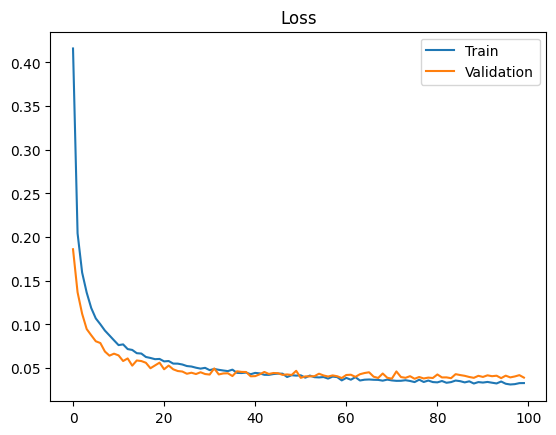

In [14]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

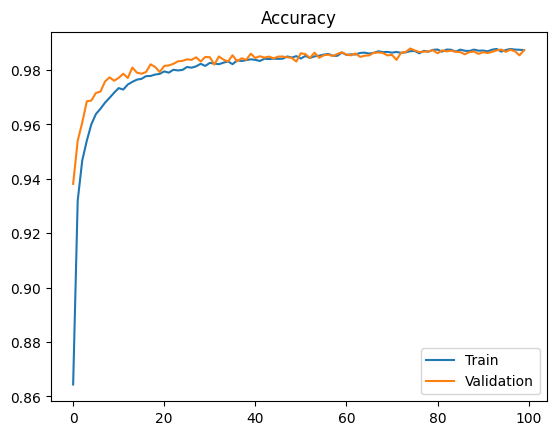

In [15]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [16]:
test_loss, test_acc = model.evaluate(X_val, y_val, batch_size = 128)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9869 - loss: 0.0399
The test loss is:  0.03907259181141853
The best accuracy is:  98.72577786445618


# Predicting on test Data


In [17]:
# header => for test data, we remove the columns "filename" and "label"
header_test = "filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean \
        spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var harmony_mean harmony_var perceptr_mean perceptr_var tempo mfcc1_mean mfcc1_var mfcc2_mean \
        mfcc2_var mfcc3_mean mfcc3_var mfcc4_mean mfcc4_var".split()

In [18]:
df_test = pd.read_csv('test_data/all_csv/data_test.csv')
df_test.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var
0,Cornell-NY-LongIsland-20090123-000000-LPfilter...,0.387097,0.225497,122.822588,193.583388,289.606582,0.002360,-330.366577,134.884445,93.309349,...,3.155356,-3.671819,-6.018852,-3.454629,0.940752,3.465086,2.600567,-0.163426,-1.985416,-1.048565
1,Tutr-multisound-NOAA-PAGroup-03-bottlenose-dol...,0.580779,0.012360,4305.353377,3026.143586,8044.438355,0.332597,-239.826141,31.434437,-7.070275,...,2.083760,5.464931,-3.501123,-0.868094,-7.742121,-0.091587,-5.063464,-2.545741,-4.337422,-2.575748
2,Stfr-Multisound-NOAA-PAGroup-01-atlantic-spott...,0.517157,0.060906,3882.642553,3364.273137,7636.442871,0.278269,-183.309372,75.157616,38.185295,...,-0.304409,6.529043,0.861367,7.027621,2.666737,4.561831,-1.460519,2.970615,-1.696198,-0.487870
3,Phma-clicks-NOAA-PAGroup-01-sperm-clip.mp3,0.735886,0.009793,4415.555121,2847.591934,7875.945224,0.334308,-253.931244,14.146472,-20.274191,...,0.119933,3.794635,-1.775898,0.321630,-4.040365,-0.753094,-5.397344,-2.292381,-5.609802,-1.893516
4,Meno-song-NOAA-PAGroup-13-humpback-clip.mp3,0.460321,0.050529,261.062685,250.870800,523.121837,0.014001,-430.309601,150.827408,94.687485,...,-2.316839,-8.536296,-5.795730,2.194222,8.474265,8.912679,4.807855,0.639276,-0.280720,1.697860


In [19]:
X_test = scaler.fit_transform(np.array(df_test.iloc[:, 1:27]))
print("X_test:", X_test)

X_test: [[-1.10634921  2.55814931 -1.36288058 -1.40175993 -1.38863142 -1.31898599
  -0.4254519   0.95508274  1.5871312   1.90421992  0.13572142 -1.07746868
  -0.84434599 -0.69383237  0.70478761  1.12224888  1.7046332  -1.20496501
  -1.32479355 -1.43070839  0.18546954 -0.07658052  1.0752874  -0.095541
  -0.02881675 -0.64679385]
 [ 0.6279938  -0.60502348  0.81744642  0.77142548  0.82858918  0.92869533
   0.47067036 -0.75650783 -0.66636384 -0.31027838 -0.46395348  0.359415
   0.82212327 -0.72788013 -0.6120903  -1.84767727  1.20081284  0.44512999
  -0.56995761 -0.62596199 -1.67434823 -1.27649574 -1.18134306 -0.91622171
  -0.68787569 -1.20066662]
 [ 0.05828571  0.11544835  0.59708992  1.03084387  0.71193726  0.55892849
   1.03004402 -0.03310353  0.3496113  -0.06947972  1.16992881  0.61350253
   1.98087406  2.0680777  -0.67417666  0.81187211  0.07799444  0.6373084
   0.73795298  1.83062578  0.55516481  0.29342872 -0.12047643  0.98410066
   0.05222529 -0.44344303]
 [ 2.0169158  -0.64311929  0

In [20]:
# generate predictions for samples
predictions = model.predict(X_test)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[2.15941102e-13 8.81000301e-23 6.19214199e-21 8.32655710e-29
  1.91572138e-20 9.99999940e-01 5.20319124e-24 1.96377763e-29
  6.00506244e-14]
 [2.30137843e-21 9.99999940e-01 6.12279513e-16 1.04013044e-12
  4.19497472e-15 2.14763764e-14 5.94906179e-15 1.95600065e-23
  1.05630823e-13]
 [5.06352826e-09 4.48879242e-13 8.68570894e-13 1.86491149e-13
  9.84154463e-01 6.12720152e-11 7.98195003e-07 5.92701131e-18
  1.58446636e-02]
 [5.99381689e-04 3.08110397e-02 8.08960557e-01 7.20760785e-04
  1.47484732e-03 1.27532694e-03 5.68353571e-04 7.29583146e-04
  1.54860184e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.99999940e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.84062053e-03 3.54895292e-07 7.98119288e-07 9.98153687e-01
  1.77993884e-10 5.12925813e-10 8.15715442e-13 8.21235874e-12
  4.41021712e-06]
 [3.41498363e-03 7.88263232e-03 7.73456335e-01 2.98024826e-02
  2.23027281e-02 1.84073243e-02 1.38344234e-02 2

In [21]:
# generate argmax for predictions
classes = np.argmax(predictions, axis = 1)
print(classes)

[5 1 4 2 5 3 2 2]


In [22]:
# transform classes number into classes name
result = encoder.inverse_transform(classes)
print(result)

['NorthernRightWhale' 'BowheadWhale' 'Long_FinnedPilotWhale'
 'HumpbackWhale' 'NorthernRightWhale' 'KillerWhale' 'HumpbackWhale'
 'HumpbackWhale']


In [23]:
df_test['filename']

0    Cornell-NY-LongIsland-20090123-000000-LPfilter...
1    Tutr-multisound-NOAA-PAGroup-03-bottlenose-dol...
2    Stfr-Multisound-NOAA-PAGroup-01-atlantic-spott...
3           Phma-clicks-NOAA-PAGroup-01-sperm-clip.mp3
4          Meno-song-NOAA-PAGroup-13-humpback-clip.mp3
5    Dele-multisound-NOAA-Castellote-01-beluga-clip...
6    Oror-Multisound-AWI-Van-Opzeeland-01-killer-cl...
7    Eugl-multisound-NOAA-PAGroup-01-right-whale-cl...
Name: filename, dtype: object

No better generalisation, but even higher accuracy on test data. So the issue is not so much variation but perhaps quality of sound -- i.e. different recording devices. 